# Pytorch LSTM Stock Predictor


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import os
import pickle

In [28]:
# Globals

INPUT_SIZE = 300
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

# Hyper parameters

learning_rate = 0.001
num_epochs = 50

In [54]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(INPUT_SIZE, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [55]:
X_train.shape,y_train.shape

((1198, 60), (1198,))

In [56]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [57]:
X_train.shape

(1198, 1, 60)

In [29]:
def loadfile(name):
    infile = open(name,'rb')
    data = pickle.load(infile)
    infile.close()
    return data
        
def saveFile(name, file):
    outfile = open(name,'wb')
    pickle.dump(file,outfile)
    outfile.close()

In [30]:
X_train = loadfile("X_train")
y_train = loadfile("y_train")

In [31]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [32]:
X_train.shape,y_train.shape

((12016, 1, 300), (12016,))

In [33]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [34]:
class TradingDataset(Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self,X_train,y_train):
        self.len = len(X_train)
         
        self.loss_func = torch.nn.MSELoss(reduction='sum')
        self.x_data = Variable(torch.from_numpy(X_train).float())
        self.y_data = Variable(torch.from_numpy(y_train).float())

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len
      


dataset = TradingDataset(X_train,y_train)
train_loader = DataLoader(dataset=dataset,
                          drop_last=True,  
                          batch_size=64)

# for local_batch, local_labels in train_loader:

In [35]:
for local_batch, local_labels in tqdm(train_loader):
    print(local_batch,local_labels)
    break

0%|          | 0/187 [00:00<?, ?it/s]tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1883]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.1883,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  ..., -1.4388, -1.2774,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ..., -1.2774,  0.0000, -1.6636]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.6636, -0.7519]]]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2.,
        2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        0., 2., 1., 2., 0., 0., 0., 0., 2., 1.])



In [36]:
model = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
# model.cuda()

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

PATH = os.path.join(os.getcwd(), "model_"+str(10)+'.model')

# inputs = Variable(torch.from_numpy(X_train).float()).cuda()
# labels = Variable(torch.from_numpy(y_train).float()).cuda()


In [37]:
for epoch in range(num_epochs):
    loss = 0
    for local_batch, local_labels in tqdm(train_loader):
        output, hidden_state = model(local_batch, hidden_state) 
    
        loss = criterion(output.view(-1), local_labels)
        optimiser.zero_grad()
        loss.backward(retain_graph=True)                     # back propagation
        optimiser.step()                                     # update the parameters

        loss += loss.item()
    
    if (epoch+1)%10==0:
          print('saving the model: '+'model_'+str(epoch+1)+'.model')
          torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model_'+str(epoch+1)+'.model'))
    
    print('epoch {}, loss {}'.format(epoch,loss))

  8%|▊         | 15/187 [04:37<53:42, 18.74s/it]

KeyboardInterrupt: 

In [40]:
# from google.colab import files
# files.download(PATH)

model.load_state_dict(torch.load(PATH,map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [41]:
weight = model.parameters()

In [33]:
for param in weight:
    add = param.data + param.data
    print(add)
    print("Done")

tensor([[-0.0589,  0.0779,  0.1582,  ...,  0.1276,  0.1023, -0.1759],
        [ 0.1959, -0.1779, -0.2056,  ..., -0.0605, -0.0178, -0.1042],
        [-0.1700, -0.2063,  0.2179,  ..., -0.0529,  0.0724, -0.2643],
        ...,
        [ 0.1671, -0.2701,  0.2087,  ...,  0.0775, -0.1742,  0.0121],
        [ 0.1533,  0.1076,  0.0166,  ..., -0.1123, -0.0593, -0.2780],
        [ 0.0135, -0.1862, -0.0508,  ...,  0.2638, -0.1093,  0.2076]])
Done
tensor([[ 0.1911, -0.0335, -0.0374,  ..., -0.1736,  0.0985,  0.2419],
        [-0.2362, -0.1586,  0.1982,  ...,  0.1743, -0.0885,  0.0770],
        [-0.1200, -0.0513,  0.1872,  ..., -0.1188, -0.0084,  0.2749],
        ...,
        [ 0.0176, -0.0396,  0.0076,  ...,  0.0299,  0.0132, -0.2374],
        [ 0.0387, -0.1275,  0.1024,  ...,  0.2088,  0.1877,  0.0034],
        [-0.1639, -0.2358,  0.0920,  ...,  0.0978,  0.1583, -0.0825]])
Done
tensor([ 2.0545e-01,  4.2005e-03,  2.7963e-02,  1.5661e-01, -5.5117e-02,
        -2.0249e-01,  9.4134e-02,  1.7432e-01,  1

In [34]:
PATH

'/Volumes/Hard Drive/Trading/pytorch-stock-predictor-rnn/model_10.model'

In [35]:
dataset_test = pd.read_csv('LTC-USD.csv',nrows=10000,names=['time','low','high','open','Close','volume'])
dataset_test.head()
print(dataset_test.shape)

(10000, 6)


In [36]:
# Getting the real stock price of 2017
# dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

real_stock_price = sc.fit_transform(real_stock_price)

X_test = []
y_test = []
for i in range(INPUT_SIZE, len(real_stock_price)):
    X_test.append(real_stock_price[i-INPUT_SIZE:i, 0])
    y_test.append(real_stock_price[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_test.shape

(9940, 1, 60)

In [37]:
hidden_state = None
test_inputs = Variable(torch.from_numpy(X_test).float())
predicted_stock_price, b = model(test_inputs, hidden_state)
# predicted_stock_price = np.reshape(predicted_stock_price.cpu().detach().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price.cpu().detach().numpy())
real_stock_price = sc.inverse_transform(y_test)

In [294]:
# batch = deque(maxlen=60)
# predicted = []
# for i in X_test[0][0]:
#     batch.append(i)

# hidden_state = None
# test_inputs = Variable(torch.from_numpy(np.array([batch])).float()).unsqueeze(-2)
# output, b = model(test_inputs, hidden_state)
# output = output.cpu().detach().numpy()
# predicted.append(sc.inverse_transform([output.item()]))
# print(output.item())

In [295]:
# for i in range(100):
#     batch.append(output.item())
#     test_inputs = Variable(torch.from_numpy(np.array([batch])).float()).unsqueeze(-2)
#     output, b = model(test_inputs, b)
#     output = output.cpu().detach().numpy()
#     predicted.append(sc.inverse_transform(output))
# predicted

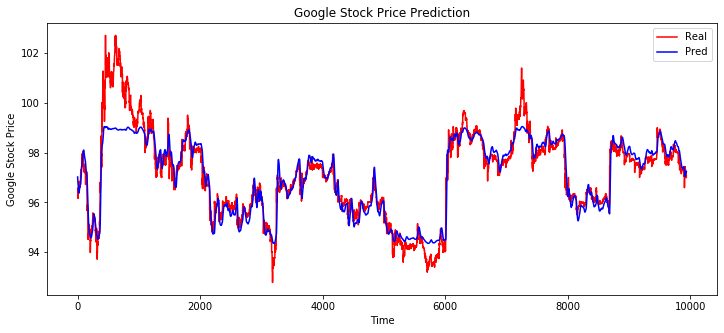

In [38]:
# Visualising the results
plt.figure(1, figsize=(12, 5))
plt.plot(real_stock_price, color = 'red', label = 'Real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Pred')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()